So this is some brief token analysis, I basically want to see the initial probability distributions for certain words for the answers. This will tell me how out of distribution tasks are.

In [33]:
from transformers import T5ForConditionalGeneration, AutoTokenizer
from alphaarc.task import Task
import torch
import matplotlib.pyplot as plt
import numpy as np 
import json

In [34]:

with open('../data/split_keys.json') as fp:
    json_object = json.load(fp)

json_object['val']

['6150a2bd',
 'c8f0f002',
 '68b16354',
 'c9e6f938',
 '6fa7a44f',
 'ac0a08a4',
 '4258a5f9',
 '9ecd008a',
 '25ff71a9',
 '3af2c5a8',
 '67e8384a',
 '56ff96f3',
 'dc1df850',
 'ae4f1146',
 'aabf363d',
 'aedd82e4',
 '445eab21',
 '41e4d17e',
 'f5b8619d',
 '00d62c1b',
 '3906de3d',
 '8d5021e8',
 '0ca9ddb6',
 'd0f5fe59',
 'ba97ae07',
 'd9fac9be',
 'ded97339',
 'f8ff0b80',
 'dbc1a6ce',
 '496994bd',
 'fcb5c309',
 'ff805c23',
 '5c0a986e',
 '7f4411dc',
 '6d75e8bb',
 'e76a88a6',
 '8f2ea7aa',
 '137eaa0f',
 '6e82a1ae',
 'a5f85a15',
 '4be741c5',
 '681b3aeb',
 '3ac3eb23',
 '253bf280',
 '3428a4f5',
 'a9f96cdd',
 '1caeab9d',
 '3de23699',
 'bdad9b1f',
 '88a62173',
 'f8b3ba0a',
 '88a10436',
 '7e0986d6',
 'd4a91cb9',
 '913fb3ed',
 '3631a71a',
 '95990924',
 '93b581b8',
 '9edfc990',
 'a65b410d',
 'ef135b50',
 '6e19193c',
 'cbded52d',
 'ae3edfdc',
 '4612dd53',
 'e48d4e1a',
 '846bdb03',
 '2204b7a8',
 'e5062a87',
 '539a4f51',
 '91413438',
 'e8dc4411',
 'e40b9e2f',
 'd6ad076f',
 'b190f7f5',
 '6cdd2623',
 'f9012d9b',

In [35]:
json_object['val']

['6150a2bd',
 'c8f0f002',
 '68b16354',
 'c9e6f938',
 '6fa7a44f',
 'ac0a08a4',
 '4258a5f9',
 '9ecd008a',
 '25ff71a9',
 '3af2c5a8',
 '67e8384a',
 '56ff96f3',
 'dc1df850',
 'ae4f1146',
 'aabf363d',
 'aedd82e4',
 '445eab21',
 '41e4d17e',
 'f5b8619d',
 '00d62c1b',
 '3906de3d',
 '8d5021e8',
 '0ca9ddb6',
 'd0f5fe59',
 'ba97ae07',
 'd9fac9be',
 'ded97339',
 'f8ff0b80',
 'dbc1a6ce',
 '496994bd',
 'fcb5c309',
 'ff805c23',
 '5c0a986e',
 '7f4411dc',
 '6d75e8bb',
 'e76a88a6',
 '8f2ea7aa',
 '137eaa0f',
 '6e82a1ae',
 'a5f85a15',
 '4be741c5',
 '681b3aeb',
 '3ac3eb23',
 '253bf280',
 '3428a4f5',
 'a9f96cdd',
 '1caeab9d',
 '3de23699',
 'bdad9b1f',
 '88a62173',
 'f8b3ba0a',
 '88a10436',
 '7e0986d6',
 'd4a91cb9',
 '913fb3ed',
 '3631a71a',
 '95990924',
 '93b581b8',
 '9edfc990',
 'a65b410d',
 'ef135b50',
 '6e19193c',
 'cbded52d',
 'ae3edfdc',
 '4612dd53',
 'e48d4e1a',
 '846bdb03',
 '2204b7a8',
 'e5062a87',
 '539a4f51',
 '91413438',
 'e8dc4411',
 'e40b9e2f',
 'd6ad076f',
 'b190f7f5',
 '6cdd2623',
 'f9012d9b',

In [36]:
task = Task.from_json(f'../data/training/c8f0f002.json')
model = T5ForConditionalGeneration.from_pretrained('../finetune-checkpoint/dev-checkpoint')


task.program_lines

'O = replace(I, SEVEN, FIVE)'

In [37]:
from alphaarc.policy.tokenize import tokenize_task
def encode_task(task, tokenizer, model, input_state_max=256, n_examples=10, max_length=256): 
    tokenized_task = np.array(tokenize_task(task, tokenizer, n_examples, input_state_max, max_length)['input_ids'])
    return tokenized_task

In [38]:
import torch
import torch.nn.functional as F
import numpy as np
from typing import Dict


 

tok      = AutoTokenizer.from_pretrained('Salesforce/codet5p-220m')

input_   = torch.tensor(encode_task(task, tok, model)).unsqueeze(0)
target_text = task.program_lines

ids      = tok(target_text, return_tensors="pt").input_ids

model.eval()
with torch.no_grad():
    outputs = model(input_ids=input_, labels=ids)
    logits = outputs.logits  
    print(outputs)

Seq2SeqLMOutput(loss=tensor(0.2818), logits=tensor([[[ 0.3831, 18.9940,  7.2761,  ..., -0.4946,  0.5922,  5.0309],
         [ 0.2336,  2.0657,  3.7528,  ...,  0.1195,  0.7402,  0.8793],
         [ 0.1117,  0.8902,  3.8408,  ..., -0.3944, -0.3186, -0.0624],
         ...,
         [ 0.0641,  0.3689,  1.5748,  ...,  0.5910, -0.9782,  0.1014],
         [ 0.0361,  0.3636,  2.7570,  ...,  0.6579, -0.4148, -0.5088],
         [ 0.4302,  6.5558, 21.4115,  ..., -2.1041, -1.9352, -0.8495]]]), past_key_values=((tensor([[[[-3.9148e-01,  4.7972e-01,  4.9054e-01,  ..., -4.5415e-01,
            2.2710e-01, -4.1471e-01],
          [ 2.3603e-01,  2.2442e-01,  2.1181e-01,  ..., -1.8054e-01,
            2.5632e-02,  2.9064e-02],
          [-2.8153e-01, -1.7814e-02, -4.4256e-03,  ..., -7.9241e-03,
           -3.4889e-01, -6.0486e-02],
          ...,
          [ 1.4530e-01, -7.6665e-02, -9.5060e-02,  ...,  5.6372e-02,
            1.8374e-01,  5.7155e-02],
          [-1.4247e-01, -3.8804e-02, -3.5147e-02,  .

In [39]:
tok      = AutoTokenizer.from_pretrained('Salesforce/codet5p-220m')
target_text = task.program_lines
model.eval()

# teacher-forcing forward pass
input_   = torch.tensor(encode_task(task, tok, model)).unsqueeze(0)

ids      = tok(target_text, return_tensors="pt").input_ids

with torch.no_grad():
    logits = model(input_, labels =ids).logits        # [1, seq_len, vocab]
log_p     = torch.log_softmax(logits, -1)

# pick out the score assigned to *each actual token*
token_logp = log_p.gather(2, ids.unsqueeze(-1)).squeeze(-1)   # [1, seq_len]
p_token    = token_logp.exp().squeeze().tolist()              # to probabilities
tokens     = tok.convert_ids_to_tokens(ids[0])


task.program_lines

val_tasks = [task]

In [40]:
import torch, json, pathlib, tqdm, pickle
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

records = []   # one entry per token

for task in tqdm.tqdm(val_tasks):
    input_ = torch.tensor(encode_task(task, tok, model)).unsqueeze(0).to(model.device)
    ids    = tok(task.program_lines, return_tensors="pt").input_ids.to(model.device)

    with torch.no_grad():
        logits = model(input_, decoder_input_ids=ids).logits          # [1, L, V]
        log_p  = torch.log_softmax(logits, -1)
        probs  = log_p.exp()

    # per-token quantities
    entropy_t = -(probs * log_p).sum(-1).squeeze(0)                     # [L]
    p_true_t  = probs.gather(2, ids.unsqueeze(-1)).squeeze(0).squeeze(-1)  # [L]
    p_max_t   = probs.max(-1).values.squeeze(0)
    correct_t = (p_true_t == p_max_t).cpu().numpy()                     # [L] bool

    print(entropy_t)
    for H, corr in zip(entropy_t.cpu().tolist(), correct_t):
        records.append((H, corr))



100%|██████████| 1/1 [00:00<00:00, 11.78it/s]

tensor([3.8173, 3.2814, 3.8124, 2.8666, 2.8004, 0.3809, 1.0360, 2.5026, 3.6469,
        2.8059, 4.0534, 3.0922, 1.6127, 2.5378, 2.4941])


Mean H when correct : 1.04  (n=1)
Mean H when wrong   : 2.84  (n=14)


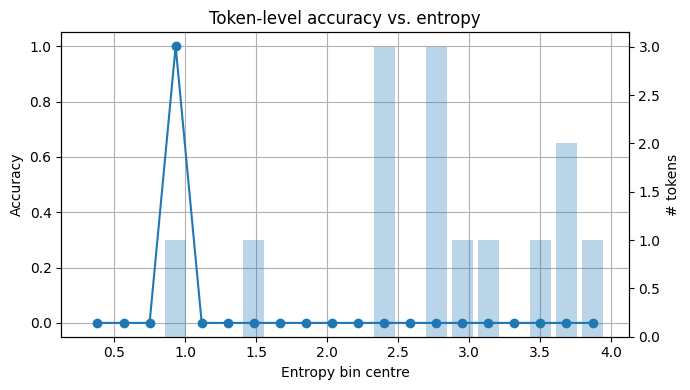

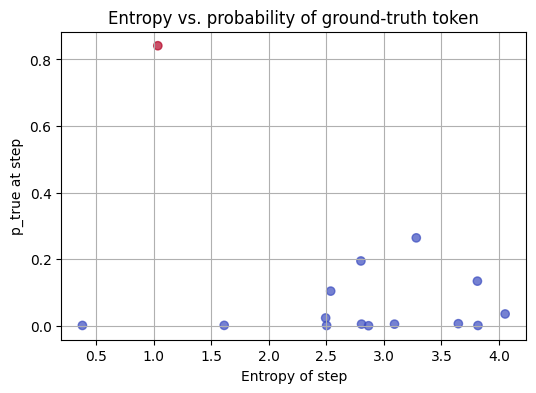

In [43]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------------
# 1.  Per-token entropy  H_t  and correctness flag  correct_t
# ------------------------------------------------------------------
probs     = log_p.exp()                                   # [1, L, V]
entropy_t = -(probs * log_p).sum(-1).squeeze(0)           # [L]

p_true_t  = probs.gather(2, ids.unsqueeze(-1)).squeeze(0).squeeze(-1)  # [L]
p_max_t   = probs.max(-1).values.squeeze(0)                              # [L]
correct_t = (p_true_t == p_max_t).float()                                # [L] – 1 iff GT token is top-1

# ------------------------------------------------------------------
# 2.  Quick numerical summary
# ------------------------------------------------------------------
ent_correct = entropy_t[correct_t.bool()]
ent_wrong   = entropy_t[~correct_t.bool()]
print(f"Mean H when correct : {ent_correct.mean():.2f}  (n={len(ent_correct)})")
print(f"Mean H when wrong   : {ent_wrong.mean():.2f}  (n={len(ent_wrong)})")

# ------------------------------------------------------------------
# 3.  Accuracy as a function of entropy (reliability style)
# ------------------------------------------------------------------
# bin by entropy
num_bins = 20
bins     = torch.linspace(entropy_t.min(), entropy_t.max(), num_bins+1)
idx      = torch.bucketize(entropy_t, bins[:-1]) - 1      # [L] → 0 … num_bins-1

acc_bin  = torch.zeros(num_bins)
cnt_bin  = torch.zeros(num_bins)

for b in range(num_bins):
    mask = idx == b
    if mask.any():
        acc_bin[b] = correct_t[mask].mean()
        cnt_bin[b] = mask.sum()

fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(bins[:-1].numpy(), acc_bin.numpy(), marker='o')
ax1.set_xlabel("Entropy bin centre")
ax1.set_ylabel("Accuracy")
ax1.set_title("Token-level accuracy vs. entropy")
ax1.grid(True)

# optional: overlay counts so you know how many tokens per bin
ax2 = ax1.twinx()
ax2.bar(bins[:-1].numpy(), cnt_bin.numpy(), width=(bins[1]-bins[0]).item()*0.8,
        alpha=0.3)
ax2.set_ylabel("# tokens")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 4.  Scatter plot (entropy, p_true) coloured by correctness
# ------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.scatter(entropy_t.numpy(), p_true_t.numpy(),
            c=correct_t.numpy(), cmap="coolwarm", alpha=0.7)
plt.xlabel("Entropy of step")
plt.ylabel("p_true at step")
plt.title("Entropy vs. probability of ground-truth token")
plt.grid(True)
plt.show()

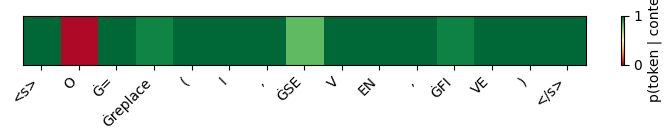

In [44]:
plt.figure(figsize=(len(tokens)*.5,1.5))
plt.imshow(np.array([p_token]), aspect="auto", cmap="RdYlGn", vmin=0, vmax=1)
plt.yticks([])
plt.xticks(range(len(tokens)), tokens, rotation=45, ha="right")
plt.colorbar(label="p(token | context)")
plt.tight_layout()
plt.show()